In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.profiler
import intel_extension_for_pytorch as ipex

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

if torch.cuda.is_available():
    device = torch.device('gpu')
elif torch.xpu.is_available():
    device = torch.device('xpu')
else:
    device = torch.device('cpu')

[W616 17:20:26.140081999 OperatorEntry.cpp:154] Warning: Warning only once for all operators,  other operators may also be overridden.
  Overriding a previously registered kernel for the same operator and the same dispatch key
  operator: aten::_addmm_activation(Tensor self, Tensor mat1, Tensor mat2, *, Scalar beta=1, Scalar alpha=1, bool use_gelu=False) -> Tensor
    registered at /pytorch/build/aten/src/ATen/RegisterSchema.cpp:6
  dispatch key: AutocastCPU
  previous kernel: registered at /pytorch/aten/src/ATen/autocast_mode.cpp:327
       new kernel: registered at /opt/workspace/ipex-cpu-dev/csrc/cpu/autocast/autocast_mode.cpp:112 (function operator())


In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 32

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

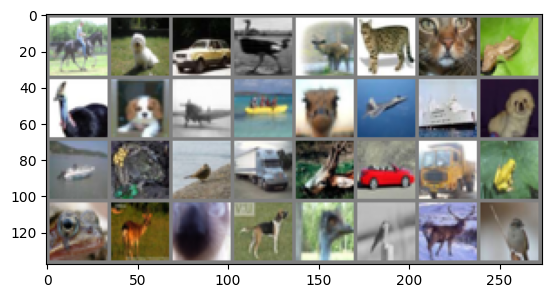

horse dog   car   bird  deer  cat   cat   frog  bird  dog   plane ship  bird  plane ship  dog   ship  frog  bird  truck deer  car   truck frog  frog  deer  cat   dog   bird  bird  deer  bird 


In [3]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [4]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 8, 5)
        self.conv2 = nn.Conv2d(8, 16, 5)
        self.conv3 = nn.Conv2d(
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
net.to(device)
print('number of params: ', sum([p.numel() for p in net.parameters()]))

number of params:  66838


In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [6]:
with torch.profiler.profile(
    activities=[
        torch.profiler.ProfilerActivity.CPU,
        torch.profiler.ProfilerActivity.XPU, # Include XPU activity
    ],
    schedule=torch.profiler.schedule(wait=1, warmup=1, active=3, repeat=1), # Example schedule
    on_trace_ready=torch.profiler.tensorboard_trace_handler('./log/xpu_profiler'),
    record_shapes=True,
    with_stack=True,
    profile_memory=True
) as prof:
    for epoch in range(2):  # loop over the dataset multiple times
    
        count_correct = 0
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = inputs.to(device, dtype=torch.float32)
            labels = labels.to(device)
    
            # zero the parameter gradients
            optimizer.zero_grad()
    
            # forward + backward + optimize
            outputs = net(inputs)
            preds = outputs.argmax(dim=1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            prof.step()
    
            # print statistics
            running_loss += loss.item()
            count_correct += preds.eq(labels).sum().item()
            if i % 200 == 0:    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
                running_loss = 0.0
    
        print(f'Epoch {epoch} accuracy: {count_correct / len(trainset)}') 
    
    print('Finished Training')
    print(prof.key_averages().table(sort_by="xpu_time_total", row_limit=10))

[1,     1] loss: 0.001
[1,   201] loss: 0.230
[1,   401] loss: 0.230
[1,   601] loss: 0.230
[1,   801] loss: 0.230
[1,  1001] loss: 0.229
[1,  1201] loss: 0.225
[1,  1401] loss: 0.217
Epoch 0 accuracy: 0.14896
[2,     1] loss: 0.001
[2,   201] loss: 0.201
[2,   401] loss: 0.197
[2,   601] loss: 0.193
[2,   801] loss: 0.189
[2,  1001] loss: 0.183
[2,  1201] loss: 0.180
[2,  1401] loss: 0.176
Epoch 1 accuracy: 0.30224
Finished Training
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg      Self XPU    Self XPU %     XPU total  XPU time avg       CPU Mem  Self CPU Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  -----------

In [7]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device, dtype=torch.float32)
        labels = labels.to(device)

        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 36 %


In [8]:
#save model
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

### Investigating the conv kernels

In [9]:
param_list = list(net.parameters())

In [10]:
param_list[0].shape

torch.Size([8, 3, 5, 5])

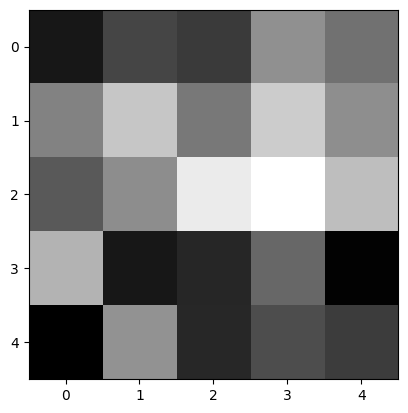

In [11]:
plt.imshow(net.conv1.weight[5, 0].cpu().detach().numpy(), cmap='grey')

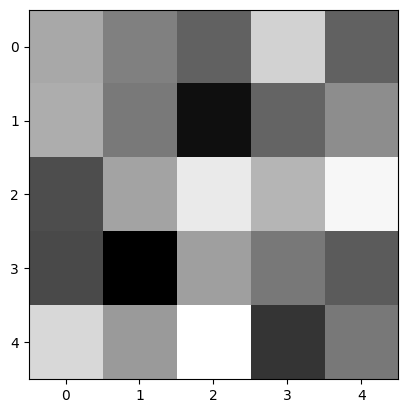

In [12]:
#compare to randomly generated kernels
plt.imshow(torch.randn(5, 5), cmap='grey')

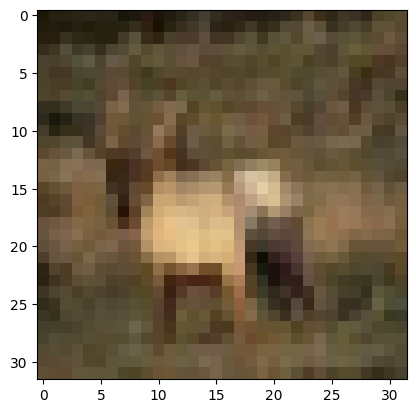

In [13]:
#call on an image
idx = 3
img = trainset.__getitem__(idx)[0].to(device)
img_conv1 = net.conv1(img.view(1, 3, 32, 32))

imshow(img.cpu().detach())

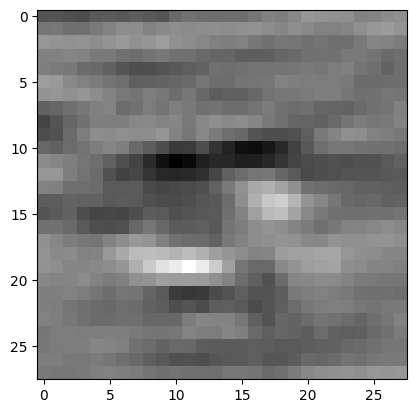

In [14]:
kernel_idx = 5
plt.imshow(img_conv1[:, kernel_idx, :, :].view(28, 28).cpu().detach().numpy(), cmap='grey')